# Mining repos from GitHub

In [14]:
import os
%load_ext autoreload
%autoreload 2
import pandas as pd
from tqdm import tqdm
pd.options.display.float_format = '{:.2f}'.format

os.chdir('D:\github_data\python')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Выставляем на [GitHub Search](https://seart-ghs.si.usi.ch/) следующие фильтры:

* язык Python
* 50+ звезд
* 1000+ коммитов
* 10+ контрибьюторов
* репозитории созданы не позднее 15 августа 2019 года (чтобы им было 2+ года)
* не берем форки
* не берем репозитории без лицензии

И скриншот, скорее чтобы удостовериться, что я все поставила правильно:

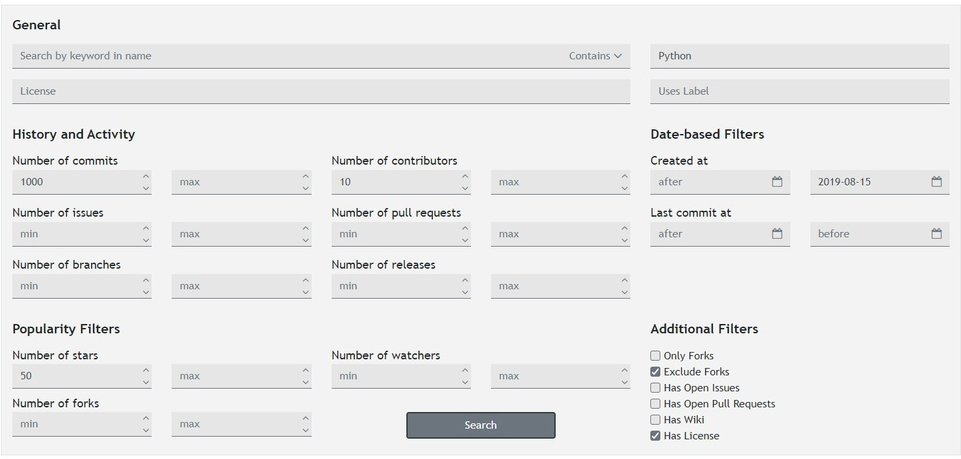

In [15]:
from IPython.display import Image
Image(filename='filters.jpg')

In [16]:
ghs_df = pd.read_csv('results.csv')
ghs_df.shape

(3146, 27)

In [17]:
ghs_df.head()

,name,fork project,commits,branches,default branch,releases,contributors,license,watchers,stargazers,...,total issues,open issues,total pull requests,open pull requests,last commit,last commit SHA,has wiki,is archived,languages,labels
0,1200wd/bitcoinlib,False,3001,5,master,0,12,GNU General Public License v3.0,14,283,...,104,13,78,1,2021-03-20 09:31:54.0,c52cdfc9fe7feaedcf4dc3e43ceca4071865281b,True,False,Python,"bug,duplicate,enhancement,help wanted,invalid,..."
1,18f/domain-scan,False,1406,8,master,0,34,Other,31,313,...,90,36,233,4,2020-10-20 21:33:42.0,62f3484c3ecc599a5a1cbd7ee66910fb28314bbe,False,False,NaN,NaN
2,18f/tock,False,2211,20,main,36,62,Other,127,115,...,668,31,652,4,2021-08-10 17:19:02.0,c127b98b319da02a166362065f4beac81ed47eeb,True,False,"Python,HTML,JavaScript,SCSS,Shell,Dockerfile","theme:content,dependencies,python,in-progress,..."
3,21dotco/two1-python,False,1943,1,master,0,30,Other,36,366,...,18,11,16,6,2017-06-07 22:32:36.0,4e833300fd5a58363e3104ed4c097631e5d296d3,True,False,"Python,Shell","RDY,RFC,WIP,bug,duplicate,enhancement,failing-..."
4,2du/opennamu,False,3585,4,beta,15,16,BSD 3-Clause New or Revised License,18,134,...,804,30,317,3,2021-04-05 11:33:46.0,c3d1578adcbe63a0e53c153f6faaf0acda5bc535,False,False,"Python,JavaScript,CSS,HTML,Dockerfile","API,개선 (Improve),공지 (Notice),기능 (Function),기타 ..."


Соберем через GitHub API дополнительную информацию о репозиториях, оставшихся после применения фильтров в GitHub Search.

In [18]:
from github import Github

# using an access token
with open('access_token.txt') as file:
    access_token = file.readline().strip()
    
g = Github(access_token)

In [19]:
repos = []
for name in tqdm(ghs_df['name']):
    try:
        repos.append(g.get_repo(name))
    except:
        print(name)
        repos.append(-1)

 22%|██▏       | 683/3146 [02:34<08:34,  4.78it/s]

duckietown/software


100%|██████████| 3146/3146 [11:48<00:00,  4.44it/s]


In [21]:
full_names = []
git_urls = []
languages = []

for repo in tqdm(repos):
    try:
        full_names.append(repo.full_name)
        git_urls.append(repo.git_url)
        languages.append(repo.language)
    except:
        full_names.append('')
        git_urls.append('')
        languages.append('null')

100%|██████████| 3146/3146 [00:00<00:00, 209701.87it/s]


In [22]:
ghs_df['full_name'] = full_names
ghs_df['git_url'] = git_urls
ghs_df['language'] = languages

In [23]:
ghs_df['license'].unique()

array(['GNU General Public License v3.0', 'Other',
       'BSD 3-Clause New or Revised License',
       'Creative Commons Zero v1.0 Universal', 'MIT License',
       'Apache License 2.0', 'Mozilla Public License 2.0',
       'GNU Affero General Public License v3.0',
       'GNU General Public License v2.0',
       'BSD 2-Clause Simplified License',
       'GNU Lesser General Public License v3.0', 'zlib License',
       'GNU Lesser General Public License v2.1', 'MIT No Attribution',
       'Creative Commons Attribution 4.0 International',
       'Boost Software License 1.0', 'Eclipse Public License 2.0',
       'PostgreSQL License', 'Eclipse Public License 1.0',
       'BSD 3-Clause Clear License', 'ISC License',
       'European Union Public License 1.1',
       'Universal Permissive License v1.0',
       'Creative Commons Attribution Share Alike 4.0 International',
       'Artistic License 2.0', 'Academic Free License v3.0',
       'The Unlicense', 'SIL Open Font License 1.1',
       

Теперь еще больше пофильтруем репозитории:

1. Отбросим репозитории, где как основной язык указан не Python
2. Отбросим репозитории с лицензиями, отличными от Apache, MIT или BSD 3-Clause
3. Отбросим совпадения по `full_name` (которые могли появиться из-за переименования/переноса репозиториев)

In [25]:
# leave repos only:
# 1. with Python as a main language
prev_len = len(ghs_df)
print(f"Before additional filtering: {prev_len}")
res_df = ghs_df.loc[ghs_df['language'] == 'Python']
print(f"After dropping repos without language=Python: {len(res_df)}, diff with previous step: {prev_len - len(res_df)}")
prev_len = len(res_df)

# 2. with Apache / MIT / BSD license
res_df = res_df.loc[res_df['license'].isin(['Apache License 2.0', 'MIT License',
                                            'BSD 3-Clause New or Revised License'])]
print(f"After dropping repos without Apache/MIT/BSD licences: {len(res_df)}, diff with previous step: {prev_len - len(res_df)}")
prev_len = len(res_df)

# drop duplicate repos
res_df = res_df.drop_duplicates(subset=['full_name'])
print(f"After dropping full_name duplicates: {len(res_df)}, diff with previous step: {prev_len - len(res_df)}")

res_df = res_df.sort_values(by='stargazers', ascending=False)

Before additional filtering: 3146
After dropping repos without language=Python: 3116, diff with previous step: 30
After dropping repos without Apache/MIT/BSD licences: 1406, diff with previous step: 1710
After dropping full_name duplicates: 1386, diff with previous step: 20


In [26]:
res_df.head()

,name,fork project,commits,branches,default branch,releases,contributors,license,watchers,stargazers,...,open pull requests,last commit,last commit SHA,has wiki,is archived,languages,labels,full_name,git_url,language
2229,public-apis/public-apis,False,3081,1,master,0,436,MIT License,3384,146810,...,42,2021-08-07 14:32:21.0,a58bea90a03edfc44ea297afbf5b353966b2355d,False,False,"Python,Shell","dependencies,Hacktoberfest,hacktoberfest-accep...",public-apis/public-apis,git://github.com/public-apis/public-apis.git,Python
2841,thealgorithms/python,False,2156,15,master,0,455,MIT License,5936,114214,...,20,2021-08-15 19:15:53.0,d009cea391414bfef17520ba6b64e4c2d97163ed,True,False,Python,"require type hints,algorithmic functions shoul...",TheAlgorithms/Python,git://github.com/TheAlgorithms/Python.git,Python
2822,tensorflow/models,False,7073,36,master,16,381,Apache License 2.0,2927,70922,...,167,2021-08-13 01:13:16.0,3db445c7b0404f9b98cbc47616bab08bfa3d8130,True,False,"Python,Jupyter Notebook,C++,Shell,Starlark,Doc...","type:migration,stat:awaiting testing,models:ar...",tensorflow/models,git://github.com/tensorflow/models.git,Python
1851,nvbn/thefuck,False,1617,2,master,16,159,MIT License,847,63318,...,41,2021-08-07 21:26:36.0,2a166a7dec3c872ef6be3870b50889500ca6a212,True,False,"Python,Dockerfile,Shell","HackIllinois,cannot reproduce,spam,upstream,zs...",nvbn/thefuck,git://github.com/nvbn/thefuck.git,Python
2088,pallets/flask,False,4409,5,main,14,408,BSD 3-Clause New or Revised License,2235,56333,...,4,2021-08-14 12:21:56.0,53eef278efd59222be406ff5be737f48c92f8313,False,False,"Python,HTML,Shell,CSS","dependencies,async,hacktoberfest-accepted,secu...",pallets/flask,git://github.com/pallets/flask.git,Python


In [28]:
print(f"{len(res_df)} repos and {res_df['commits'].sum()} commits")

1386 repos and 5508910 commits


In [30]:
res_df.to_csv('filtered_result.csv')
res_df['name'].to_csv('repos_names.txt', index=None, header=None)
res_df['git_url'].to_csv('repos_urls.txt', index=None, header=None)